In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
%matplotlib inline

## Sparse Matrices and Finite Differences

So, starting from our usual $N+1$ point, equi-spaced mesh, $x_{j}=a+j\delta x$, $\delta x = (b-a)/N$, we have our second-order, finite-difference approximation to $f'(x_{j})$ given by 

$$
f'(x_{j}) = \frac{1}{2\delta x}\left(f_{j+1}-f_{j-1}\right), ~ 1\leq j \leq N-1.  
$$

Now, how can we think about this in a global sense?  The best way is through linear algebra, where we write

$$
\frac{1}{2\delta x}\begin{pmatrix}-1 & 0 & 1 & 0 & \cdots & 0\\ 
0 & -1 & 0 & 1 & \cdots & 0\\
\vdots & \ddots & \ddots & \ddots & \ddots & \vdots\\
0 & \cdots & 0 & -1 & 0 & 1\\
\end{pmatrix}\begin{pmatrix}f(x_{0})\\ f(x_{1}) \\ f(x_{2}) \\ \vdots \\ f(x_{N})\end{pmatrix} \approx \begin{pmatrix}f'(x_{1})\\ f'(x_{2}) \\  f'(x_{3}) \\\vdots \\ f'(x_{N-1})\end{pmatrix}
$$

As we can see, the matrix in the left hand side is mostly just zeros.  Such a matrix is described as _sparse_.  How we define and work with sparse matrices is special within NumPy.  

In [2]:
def sparse_first_derivative(fvals, dx):
    Np1 = fvals.size
    ovec = np.ones(Np1)
    zvec = np.zeros(Np1)
    dmat = 1./(2.*dx)*spdiags(np.array([-ovec,zvec,ovec]),np.array([0,1,2]),Np1-2,Np1)
    return dmat

In [3]:
Npts = 5
xvals = np.linspace(0.,2.*np.pi,Npts+1)
dx = xvals[1] - xvals[0]
fvals = np.sin(xvals) # use f(x) = sin(x) for your test function
dftrue = np.cos(xvals)
dmat = sparse_first_derivative(fvals, dx)

In [4]:
print(dmat.todense())

[[-0.39788736  0.          0.39788736  0.          0.          0.        ]
 [ 0.         -0.39788736  0.          0.39788736  0.          0.        ]
 [ 0.          0.         -0.39788736  0.          0.39788736  0.        ]
 [ 0.          0.          0.         -0.39788736  0.          0.39788736]]


### A note about NumPy arrays and vectors.

So when we write `fvals=np.sin(xvals)`, that generates a NumPy array.  But an array is not something we can multiply by a matrix.  For that, we need a vector.  The easiest way to do this is through the somewhat strange command `fvals.reshape(-1,1)`. See the example below.  

In [5]:
print(fvals)
print(fvals.shape)
print(fvals.reshape(-1,1))
print((fvals.reshape(-1,1)).shape)
dfapprox = dmat @ fvals.reshape(-1,1)
print(dfapprox)

[ 0.00000000e+00  9.51056516e-01  5.87785252e-01 -5.87785252e-01
 -9.51056516e-01 -2.44929360e-16]
(6,)
[[ 0.00000000e+00]
 [ 9.51056516e-01]
 [ 5.87785252e-01]
 [-5.87785252e-01]
 [-9.51056516e-01]
 [-2.44929360e-16]]
(6, 1)
[[ 0.23387232]
 [-0.61228569]
 [-0.61228569]
 [ 0.23387232]]


Text(0.5, 0, '$x$')

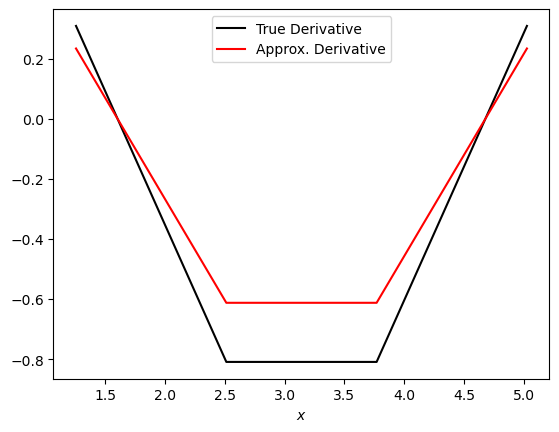

In [6]:
plt.plot(xvals[1:-1], dftrue[1:-1],color='k',label="True Derivative")
plt.plot(xvals[1:-1], dfapprox,color='r',label="Approx. Derivative")
plt.legend()
plt.xlabel(r"$x$")

## Solving a Boundary-Value Problem

Suppose I want to solve, the albeit, simple differential equation 

$$
T''(x) = f(x), ~ a < x < b, 
$$

with the _boundary conditions_ $T(a)=u_{l}$ and $T(b)=u_{r}$.  We can think of this problem as modelling the temperature of a long, narrow corridor with walls at $a$ and $b$ kept at a fixed temperature and $f(x)$ represents a heat source in the hall.  To solve this problem, we introduce a discretized mesh with $N+1$ points where 

$$
x_{j} = a + j\delta x, ~ \delta x = \frac{b-a}{N}, ~ j=0,\cdots,N.
$$

For the points $\left\{x_{j}\right\}_{j=1}^{N-1}$, we have the centered-difference approximations to the second derivative so that 

$$
T''(x_{j}) \approx \frac{1}{(\delta x)^{2}}\left(T_{j-1} - 2T_{j} + T_{j+1}\right), ~ j=1,\cdots,N-1.
$$

with the boundary conditions

$$
T_{0} = u_{l}, ~ T_{N} = u_{r}.
$$

If I then give you the data $\left\{f_{j}\right\}_{j=1}^{N-1}$ where $f_{j}=f(x_{j})$, then we get the following linear algebra problem 

$$
\frac{1}{(\delta x)^{2}}\begin{pmatrix} -2 & 1 & &\\
1 & -2 & 1 &\\
 & & \ddots & & \\
 & & 1 & -2 & 1\\
 & & & 1 & -2
\end{pmatrix} \begin{pmatrix} T_{1} \\ T_{2} \\ \vdots \\ T_{N-2} \\ T_{N-1}\end{pmatrix} = \begin{pmatrix} f_{1} - \frac{u_{l}}{(\delta x)^{2}} \\ f_{2} \\ \vdots \\ f_{N-2} \\ f_{N-1} - \frac{u_{r}}{(\delta x)^{2}} \end{pmatrix}
$$

Using the code fragment below, write a program that finds $T$ given $a$, $b$, $N$, $f$, $u_{l}$, and $u_{r}$.

In [13]:
def temp_find(a,b,fvals,ul,ur):
    Np1 = fvals.size
    dx = (b-a)/(Np1-1)
    idx2 = 1./(dx*dx)
   
    # Build the right-hand side of your problem
    rhs = fvals[1:-1]
    rhs[0] -= ul*idx2 # include left-side boundary condition
    rhs[-1] -= ur*idx2 # include right-side boundary condition
   
    diag = -2.*idx2*np.ones(Np1-2)
    odiag = idx2*np.ones(Np1-2)
    data = np.array([diag,odiag,odiag])
    dvals = np.array([0,-1,1])
    Amat = spdiags(data, dvals, Np1-2, Np1-2,format='csc')
    Tvec = spsolve(Amat,rhs)
   
    return Tvec 

Text(0, 0.5, '$T(x)$')

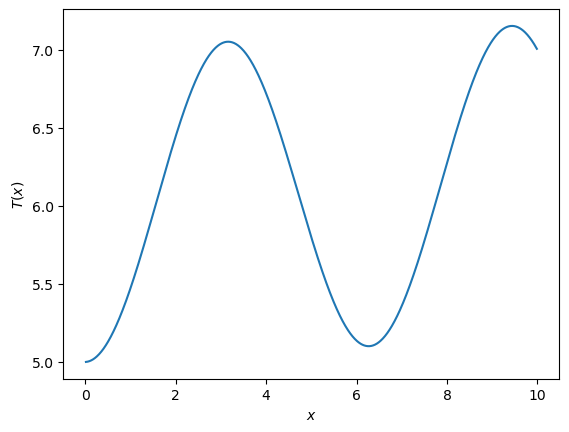

In [14]:
ffun = lambda x: np.cos(x)
a = 0.
b = 10.
ul = 5.
ur = 7.
Nvls = 1000
xvals = np.linspace(a,b,Nvls+1)
fvals = ffun(xvals)

tprofile = temp_find(a,b,fvals,ul,ur)
plt.plot(xvals[1:Nvls],tprofile)
plt.xlabel("$x$")
plt.ylabel("$T(x)$")

## More Complicated Examples

Now suppose that I want to solve the more complicated problem  

$$
-T''(x) + V(x)T(x) = f(x), ~ a < x < b, ~T(a)=t_{l}, ~T(b)=t_{r}
$$

This problem is motivated by a number of problems in quantum mechanics among other places.  We call $V(x)$ a _potential_.  For example, a very common choice of $V(x)=x^{2}$.  Let's see what introducing this does to our problem.  

Now from a discretization point-of-view, we have relative to our usual mesh that

$$
-T''(x_{j}) + V(x_{j})T(x_{j}) = f(x_{j}),
$$

so doing our usual thing, we then have for $2\leq j \leq N-2$ that

$$
-\frac{1}{(\delta x)^{2}}\left(T_{j-1}-2T_{j}+T_{j+1}\right) + V_{j}T_{j} = f_{j}
$$

and at each edge, we take into acount the boundary conditions so that

$$
-\frac{1}{(\delta x)^{2}}\left(-2T_{1}+T_{2}\right) + V_{1}T_{1} = f_{1}+\frac{t_{l}}{(\delta x)^{2}}
$$

and

$$
-\frac{1}{(\delta x)^{2}}\left(T_{N-2}-2T_{N-1}\right) + V_{N-1}T_{N-1} = f_{N-1}+\frac{t_{r}}{(\delta x)^{2}}
$$

# Linear Algebra Theory - Just in case

### Solvability for Square Matrices

* Note, for ${\bf x},{\bf y} \in \mathbb{R}^{n}$, we define the _inner-product_  $\left<{\bf x},{\bf y}\right>$ to be
$$
\left<{\bf x},{\bf y}\right> = {\bf y}^{T}{\bf x} = \sum_{j=1}^{n}y_{j}x_{j}.
$$
Show $\left<{\bf x},{\bf y}\right> = \left<{\bf y},{\bf x}\right>$, and for a square matrix $A$ that $\left<A{\bf x},{\bf y}\right> = \left<{\bf x},A^{T}{\bf y}\right>$.     

We now suppose that in our $A{\bf x} = {\bf b}$ problem that $A$ is a $n\times n$ square matrix of real values.  In general we have three outcomes to the question of whether a solution ${\bf x}$ exists to this problem
* There exists ${\bf y}$ such that $A^{T}{\bf y}=0$ but $\left<{\bf b},{\bf y} \right>\neq 0$.  Then **no** solution ${\bf x}$ exists to the problem.  
* $\left<{\bf b},{\bf y} \right> = 0$ for all ${\bf y}\neq 0$ and $A^{T}{\bf y} = 0$.  Then an **infinite** number of solutions exists of the form 
$$
{\bf x} = {\bf x}_{h} + {\bf x}_{p}, 
$$ 
where $A{\bf x}_{h} = 0$ and $A{\bf x}_{p}={\bf b}$.  Note, we have an infinite number of solutions since for any constant $c\in \mathbb{R}$, we have 
$$
A\left(c{\bf x}_{h} + {\bf x}_{p} \right) = c A{\bf x}_{h} + A{\bf x}_{p} = {\bf b}.
$$
* The only solution to $A^{T}{\bf y}=0$ is ${\bf y}=0$.  Then we say a matrix $A^{-1}$ exists, where $AA^{-1}=A^{-1}A=I$ and we have the **unique** solution 
$$
{\bf x} = A^{-1}{\bf b}.
$$

There are several equivalent criteria which establish whether a square matrix $A$ has an inverse.  The most important are 
* The only solution to $A{\bf x}=0$ is ${\bf x}=0$.
* The determinant of $A$ is non-zero, or $\mbox{det}(A)\neq 0$.  


## Norms

We also need a notion of the size of a vector.  We thus define the _2-norm_ of a vector ${\bf x}\in \mathbb{R}^{n}$ to be $\left|\left|{\bf x}\right|\right|_{2}$ where

$$
\left|\left|{\bf x}\right|\right|_{2} = \left(\sum_{j=1}^{n}\left|x_{j} \right|^{2} \right)^{1/2}.
$$

_Problems_: Show 
* $\left|\left|{\bf x}\right|\right|_{2} = 0 $ if and only if ${\bf x} = {\bf 0}$.
* For any scalar values $\lambda \in \mathbb{R}$, $\left|\left|\lambda{\bf x}\right|\right|_{2} = \left|\lambda\right| \left|\left|{\bf x}\right|\right|_{2}$.
* If we define $\hat{{\bf x}} = {\bf x}/\left|\left|{\bf x}\right|\right|_{2}$, then $\left|\left|\hat{{\bf x}}\right|\right|_{2} = 1 $.

We have some definitions to keep in mind about different types of matrices.  

* If $m=n$, we say the matrix $A$ is square.  
* If $m<n$, we say the matrix problem $A{\bf x}={\bf b}$ is _underdetermined_, i.e. there are fewer equations than there are unknowns.  
* If $m>n$, we say the matrix problem $A{\bf x}={\bf b}$ is _overdetermined_, i.e. there are more equations than there are unknowns.  
* For $m\times n$ matrix $A$, we define its _transpose, $A^{T}$ to be the $n \times m$ matrix with entries $A^{T}_{ij} = A_{ji}$.  Visually, we see that $A^{T}$ is flipped relative to $A$, i.e. 
$$
A^{T} = \begin{pmatrix} A_{11} & A_{21} & \cdots & A_{m1} \\ A_{12} & A_{22} & \cdots & A_{m2}\\ \vdots & \vdots & \ddots & \vdots \\ A_{1n} & A_{2n} & \cdots & A_{mn} \end{pmatrix},~ A^{T}:\mathbb{R}^{m}\rightarrow \mathbb{R}^{n}
$$
* Using the rules of matrix multiplication, if $A$ is an $m\times n$ matrix, then $A^{T}A$ is an $n \times n$ matrix and $AA^{T}$ is a $m \times m$ matrix.  Thus for an overdetermined problem, we can transform it into a square problem of the form 
$$
A^{T}A {\bf x} = A^{T}{\bf b}.
$$

Underdetermined problems are a bit messier to cope with.  To do so, we need to get more comfortable with norms.  To that end then:

_Problems_: Show 
* $\left|\left|{\bf x}\right|\right|^{2}_{2} = {\bf x}^{T}{\bf x}$
* Show $(A^{T}A)^{T} = A^{T}A$ and $(AA^{T})^{T} = AA^{T}$.  Matrices which are equal to their own transpose are called _symmetric_ or _self-adjoint_.
* Suppose $A^{T}{\bf y} = 0$.  Show that if a solution to $A{\bf x}={\bf b}$ exists, then $\left<{\bf b},{\bf y}\right>=0$.  
* For ${\bf x},{\bf y} \in \mathbb{R}^{n}$, show the _Cauchy-Schwarz_ inequality 
$$
\left|\left<{\bf x},{\bf y}\right>\right| = \left|\sum_{j=1}^{n}x_{j}y_{j}\right| \leq \left(\sum_{j=1}^{n}|x_{j}|^{2}\right)^{1/2}\left(\sum_{j=1}^{n}|y_{j}|^{2}\right)^{1/2} = \left|\left|{\bf x}\right|\right|_{2}\left|\left|{\bf y}\right|\right|_{2}.
$$
Note, the triangle inequality for real numbers, $|a+b|\leq |a|+|b|$ gives us via an inductive argument that 
$$
\left|\sum_{j=1}^{n}x_{j}y_{j}\right| \leq \sum_{j=1}^{n}\left|x_{j}\right|\left|y_{j}\right|
$$
* Using the Cauchy-Schwarz inequality and the triangle inequality, where $|a+b|\leq |a|+|b|$, show 
$$
\left|\left|{\bf x}+{\bf y}\right|\right|_{2} \leq \left|\left|{\bf x}\right|\right|_{2} + \left|\left|{\bf y}\right|\right|_{2}.
$$

### Eigenvalues and Symmetric Matrices

We say that a constant $\lambda \in \mathbb{C}$ is an _eigenvalue_ of a square matrix $A$ if there exists some vector ${\bf v}$ such that 
$$
A{\bf v} = \lambda {\bf v}.
$$
We call ${\bf v}$ an _eigenvector_.  Note, the above equation is equivalent to 
$$
(A - \lambda I){\bf v} = 0,
$$
which is equivalent to requiring that $\mbox{det}(A-\lambda I)=0$.  Note, we are usually obliged to worry about complex eigenvalues and eigenvectors for even real matrices.  

_Problem_: For 
$$
A = \begin{pmatrix} 0 & -1 \\ 1 & 0\end{pmatrix},
$$
find its eigenvalues and eigenvectors.  

However, we are only going to work with symmetric matrices where $A^{T}=A$.  In this case, one can show that $\lambda$ and its corresponding ${\bf v}$ are real.  This essentially comes from the formula
$$
\lambda \left|\left|{\bf v}\right|\right|^{2} = \left<A{\bf v},{\bf v} \right> = \left<{\bf v},A{\bf v} \right>.
$$
Thus, we get for symmetric matrices the formula for the eigenvalues $\lambda$
$$
\lambda = \left<A\hat{{\bf v}},\hat{{\bf v}} \right>, ~ \hat{{\bf v}} = {\bf v}/ \left|\left|{\bf v}\right|\right|.
$$

_Problem_: Show 
* For symmetric matrix $A$ that if it has two unequal eigenvalues, say $\lambda_{1}$ and $\lambda_{2}$, with 
$$
A{\bf v}_{1} = \lambda_{1}{\bf v}_{1}, ~ A{\bf v}_{2} = \lambda_{2}{\bf v}_{2}
$$
that $\left<{\bf v}_{1},{\bf v}_{2} \right>=0$.
* Suppose that for a symmetric matrix $A$, we find two eigenvectors, say ${\bf v}_{1}$ and ${\bf v}_{2}$ for the same eigenvalue $\lambda$.  Show that one can find two eigenvectors $\hat{\bf v}_{1}$ and $\hat{\bf v}_{2}$ such that 
$$
A\hat{\bf v}_{j} = \lambda \hat{\bf v}_{j}, ~ \left<\hat{{\bf v}}_{1}, \hat{{\bf v}}_{2}\right>=0.
$$
* Suppose one has found $j-1$ eigenvalues and eigenvectors, say $\lambda_{l}$ and $\hat{{\bf v}}_{l}$, $l=1,\cdots,j-1$, of the matrix $A$, and $\left<\hat{{\bf v}}_{l},\hat{{\bf v}}_{k} \right>=\delta_{lk}$.  Note, we do not require that the values $\lambda_{l}$ all be distinct, i.e. eigenvalues can repeat.  Suppose one has a unit vector $\hat{{\bf x}}$ such that 
$$
\left<\hat{{\bf x}},\hat{{\bf v}}_{l} \right> = 0.
$$
Show that 
$$
\left<\hat{{\bf x}},\sum_{l=1}^{j-1}c_{l}\hat{{\bf v}}_{l} \right>  = 0, ~ c_{l} \in \mathbb{R}.
$$